Call Worlds Bank API to get Country Income Classification

In [ ]:
import requests
import pandas as pd

# World Bank API endpoints for each income level
API_URL = "https://api.worldbank.org/v2/country"
INCOME_CODES = {
    'Low income': 'LIC',
    'Lower middle income': 'LMC',
    'Upper middle income': 'UMC',
    'High income': 'HIC'
}

records = []
for tier, code in INCOME_CODES.items():
    # fetch all pages
    page = 1
    while True:
        r = requests.get(API_URL,
                         params={'incomeLevel': code, 'format': 'json', 'page': page, 'per_page': 1000})
        data = r.json()
        # data[1] is the list of countries
        for c in data[1]:
            records.append({
                'Country': c['name'],
                'IncomeGroup': tier
            })
        # pagination
        total = int(data[0]['total'])
        per_page = int(data[0]['per_page'])
        if page * per_page >= total:
            break
        page += 1

# save to CSV
df = pd.DataFrame(records)
df.to_csv('data/country_income_test.csv', index=False, encoding='utf-8')
print("Saved country_income.csv with", len(df), "rows.")


Call ROR API to get the country of affiliation

In [ ]:
import pandas as pd
import requests
import time
import os
import csv

INPUT_FILE = "data/pred/dataset/csv/authors.csv"
OUTPUT_FILE = "data/pred/metadata/pred_authors_country_affiliation.csv"


def get_country_from_ror(aff):
    if pd.isna(aff) or aff == "NULL" or aff.strip() == "":
        return None
    try:
        url = "https://api.ror.org/organizations"
        resp = requests.get(url, params={"query": aff}, timeout=10)
        if resp.status_code == 200:
            data = resp.json()
            if data.get("number_of_results", 0) > 0:
                first_item = data["items"][0]
                if "locations" in first_item and first_item["locations"]:
                    return first_item["locations"][0]["geonames_details"].get("country_name")
    except Exception as e:
        print(f"Error for {aff}: {e}")
    return None


def main():
    df = pd.read_csv(INPUT_FILE)

    df = df[
       
        df["affiliations"].notna()
        & (df["affiliations"] != "NULL")
        & (df["affiliations"].str.strip() != "")
    ].copy()

    print(f"There are {len(df)} records to process.")

    if os.path.exists(OUTPUT_FILE) and os.path.getsize(OUTPUT_FILE) > 0:
        done_df = pd.read_csv(OUTPUT_FILE)
        done_ids = set(done_df["id"].astype(str))
        print(f"{len(done_ids)} results detected, these will be skipped.")
        write_header = False
    else:
        done_ids = set()
        write_header = True

    with open(OUTPUT_FILE, "a", encoding="utf-8", newline="") as f_out:
        writer = csv.writer(f_out)

        if write_header:
            writer.writerow(["id", "name", "gs_a_id", "affiliations", "country"])

        for _, row in df.iterrows():
            author_id = str(row["id"])
            if author_id in done_ids:
                continue 

            aff = row["affiliations"]
            country = get_country_from_ror(aff)

            writer.writerow([author_id, row["name"], row["gs_a_id"], aff, country])
            f_out.flush()

            time.sleep(1)  


if __name__ == "__main__":
    main()


Income Class Distribution - affiliation based

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency

# affiliation based
bad_df  = pd.read_csv('data/pred/metadata/pred_authors_country_affiliation.csv',  encoding='latin1')
good_df = pd.read_csv('data/norm/metadata/norm_authors_country_affiliation.csv', encoding='latin1')
income_df = pd.read_csv('data/country_income.csv')  

bad_map  = pd.merge(
    bad_df[['country']].rename(columns={'country':'Country'}),
    income_df,
    on='Country',
    how='inner'
)
good_map = pd.merge(
    good_df[['country']].rename(columns={'country':'Country'}),
    income_df,
    on='Country',
    how='inner'
)

bad_counts  = bad_map ['IncomeGroup'].value_counts().sort_index()
good_counts = good_map['IncomeGroup'].value_counts().sort_index()

contingency = pd.DataFrame({
    'Predatory': bad_counts,
    'Regular'  : good_counts
}).fillna(0).astype(int)

chi2, p, dof, expected = chi2_contingency(contingency)

proportions = contingency.div(contingency.sum(axis=0), axis=1)

print("Contingency Table (counts):")
print(contingency, "\n")

print("Proportions by IncomeGroup:")
print(proportions, "\n")

print(f"Chi² = {chi2:.3f}, p = {p:.3f}, dof = {dof}\n")

print("Expected frequencies under H0 (no difference):")
print(pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))


Contingency Table (counts):
                     Predatory  Regular
IncomeGroup                            
High income                421      372
Low income                   9        2
Lower middle income        296       28
Upper middle income        167       55 

Proportions by IncomeGroup:
                     Predatory   Regular
IncomeGroup                             
High income           0.471445  0.814004
Low income            0.010078  0.004376
Lower middle income   0.331467  0.061269
Upper middle income   0.187010  0.120350 

Chi² = 161.722, p = 0.000, dof = 3

Expected frequencies under H0 (no difference):
                      Predatory     Regular
IncomeGroup                                
High income          524.554815  268.445185
Low income             7.276296    3.723704
Lower middle income  214.320000  109.680000
Upper middle income  146.848889   75.151111


Income Class Distribution - lastname based

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency

# name based
bad_df  = pd.read_csv('data/pred/metadata/pred_author_country_lastname.csv',  encoding='latin1')
good_df = pd.read_csv('data/norm/metadata/norm_author_country_lastname.csv', encoding='latin1')
income_df = pd.read_csv('data/country_income.csv') 

bad_map  = pd.merge(
    bad_df[['Origin Country']].rename(columns={'Origin Country':'Country'}),
    income_df,
    on='Country',
    how='inner'
)
good_map = pd.merge(
    good_df[['Origin Country']].rename(columns={'Origin Country':'Country'}),
    income_df,
    on='Country',
    how='inner'
)

bad_counts  = bad_map ['IncomeGroup'].value_counts().sort_index()
good_counts = good_map['IncomeGroup'].value_counts().sort_index()

contingency = pd.DataFrame({
    'Predatory': bad_counts,
    'Regular'  : good_counts
}).fillna(0).astype(int)

chi2, p, dof, expected = chi2_contingency(contingency)

proportions = contingency.div(contingency.sum(axis=0), axis=1)

print("Contingency Table (counts):")
print(contingency, "\n")

print("Proportions by IncomeGroup:")
print(proportions, "\n")

print(f"Chi² = {chi2:.3f}, p = {p:.3f}, dof = {dof}\n")

print("Expected frequencies under H0 (no difference):")
print(pd.DataFrame(expected, index=contingency.index, columns=contingency.columns))


Contingency Table (counts):
                     Predatory  Regular
IncomeGroup                            
High income               1616     4545
Low income                 135       88
Lower middle income       2263     1661
Upper middle income       1558     2475 

Proportions by IncomeGroup:
                     Predatory   Regular
IncomeGroup                             
High income           0.290022  0.518303
Low income            0.024228  0.010035
Lower middle income   0.406138  0.189417
Upper middle income   0.279612  0.282244 

Chi² = 1042.341, p = 0.000, dof = 3

Expected frequencies under H0 (no difference):
                       Predatory      Regular
IncomeGroup                                  
High income          2393.772540  3767.227460
Low income             86.643609   136.356391
Lower middle income  1524.616693  2399.383307
Upper middle income  1566.967157  2466.032843


Top 10 Countries Distribution

In [4]:
import pandas as pd

def top_affiliation_countries(file_path, top_n=10, save_path=None):

    df = pd.read_csv(file_path)

    df = df[df["country"].notna() & (df["country"] != "None")]

    counts = df["country"].value_counts()

    top = counts.head(top_n)

    total = len(df)
    percentages = (top / total * 100).round(2)

    result = pd.DataFrame({
        "count": top,
        "percentage": percentages
    })

    if save_path:
        result.to_csv(save_path)

    return result

def top_lastname_countries(file_path, top_n=10, save_path=None):
    df = pd.read_csv(file_path)
    df = df[df["Origin Country"].notna() & (df["Origin Country"] != "None")]
    counts = df["Origin Country"].value_counts()
    top = counts.head(top_n)
    total = len(df)
    percentages = (top / total * 100).round(2)

    result = pd.DataFrame({
        "count": top,
        "percentage": percentages
    })

    if save_path:
        result.to_csv(save_path)

    return result



In [17]:
res = top_affiliation_countries("data/norm/metadata/norm_authors_country_affiliation.csv", top_n=10)
res

,count,percentage
country,,
United States,169,36.98
United Kingdom,34,7.44
South Korea,34,7.44
China,32,7.00
Germany,30,6.56
India,19,4.16
Italy,13,2.84
Australia,9,1.97
Argentina,9,1.97


In [5]:
res = top_affiliation_countries("data/pred/metadata/pred_authors_country_affiliation.csv", top_n=10)
res

,count,percentage
country,,
United States,233,26.06
Nigeria,176,19.69
China,63,7.05
United Kingdom,46,5.15
Bangladesh,37,4.14
Iraq,30,3.36
India,29,3.24
Malaysia,22,2.46
Canada,21,2.35


In [6]:
res = top_lastname_countries("data/norm/metadata/norm_author_country_lastname.csv", top_n=10)
res

,count,percentage
Origin Country,,
China,1506,16.96
India,1018,11.46
Germany,640,7.21
Italy,619,6.97
United Kingdom,577,6.50
Spain,471,5.30
Iran,341,3.84
France,293,3.30
Saudi Arabia,224,2.52


In [7]:
res = top_lastname_countries("data/pred/metadata/pred_author_country_lastname.csv", top_n=10)
res

,count,percentage
Origin Country,,
Nigeria,760,13.52
India,723,12.86
China,505,8.99
Saudi Arabia,346,6.16
Indonesia,310,5.52
Iran,251,4.47
Italy,190,3.38
Turkiye,186,3.31
Spain,176,3.13


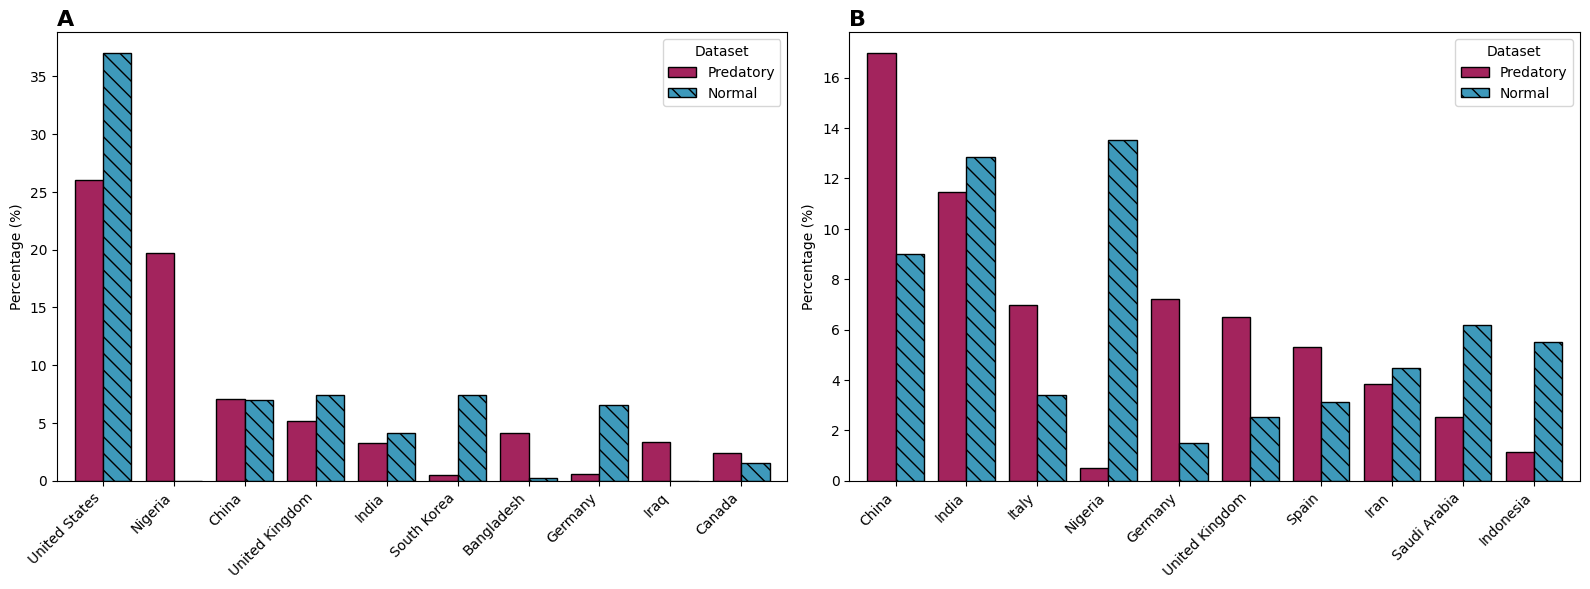

Plot A results:
                Predatory  Normal
United States       26.06   36.98
Nigeria             19.69    0.00
China                7.05    7.00
United Kingdom       5.15    7.44
India                3.24    4.16
South Korea          0.45    7.44
Bangladesh           4.14    0.22
Germany              0.56    6.56
Iraq                 3.36    0.00
Canada               2.35    1.53

Plot B results:
                Predatory  Normal
China               16.96    8.99
India               11.46   12.86
Italy                6.97    3.38
Nigeria              0.51   13.52
Germany              7.21    1.48
United Kingdom       6.50    2.54
Spain                5.30    3.13
Iran                 3.84    4.47
Saudi Arabia         2.52    6.16
Indonesia            1.13    5.52


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_country_distributions_ab(
    file1_a, file2_a, file1_b, file2_b,
    column_a="country", column_b="Origin Country",
    top_n=10, 
    labels=("Dataset1", "Dataset2"), 
    save_path=None
):
    
    COLOR_Normal = '#3e99bb'
    COLOR_Pred = '#a3245d'
    
    def load_counts(path, column_name):
        df = pd.read_csv(path)
        df = df[df[column_name].notna() & (df[column_name] != "None")]
        counts = df[column_name].value_counts(normalize=False)
        return counts, len(df)

    def prepare_data(file1, file2, column_name):
        counts1, total1 = load_counts(file1, column_name)
        counts2, total2 = load_counts(file2, column_name)
        
        combined = (counts1.add(counts2, fill_value=0)).sort_values(ascending=False)
        top_countries = combined.head(top_n).index.tolist()
        
        data = pd.DataFrame({
            labels[0]: counts1.reindex(top_countries).fillna(0).astype(int),
            labels[1]: counts2.reindex(top_countries).fillna(0).astype(int),
        }, index=top_countries)
        
        data_pct = pd.DataFrame({
            labels[0]: (data[labels[0]] / total1 * 100).round(2),
            labels[1]: (data[labels[1]] / total2 * 100).round(2),
        }, index=top_countries)
        
        return data_pct

    # Prepare data for both plots
    data_pct_a = prepare_data(file1_a, file2_a, column_a)
    data_pct_b = prepare_data(file1_b, file2_b, column_b)

    # Create figure with 1 row, 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot A
    data_pct_a.plot(
        kind="bar", 
        ax=ax1, 
        width=0.8,
        color=[COLOR_Pred, COLOR_Normal],
        edgecolor='black',
        linewidth=1
    )
 
    bars = ax1.patches
    n_countries = len(data_pct_a)
    for i, bar in enumerate(bars):
        if i >= n_countries: 
            bar.set_hatch('\\\\')
    
    ax1.set_ylabel("Percentage (%)")
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xticklabels(ax1.get_xticklabels(), ha="right")
    ax1.legend(title="Dataset")
    ax1.text(0, 1.05, 'A', transform=ax1.transAxes, 
             fontsize=16, fontweight='bold', va='top')

    # Plot B
    data_pct_b.plot(
        kind="bar", 
        ax=ax2, 
        width=0.8,
        color=[COLOR_Pred, COLOR_Normal],
        edgecolor='black',
        linewidth=1
    )
   
    bars = ax2.patches
    n_countries = len(data_pct_b)
    for i, bar in enumerate(bars):
        if i >= n_countries: 
            bar.set_hatch('\\\\')
    
    ax2.set_ylabel("Percentage (%)")
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_xticklabels(ax2.get_xticklabels(), ha="right")
    ax2.legend(title="Dataset")
    ax2.text(0, 1.05, 'B', transform=ax2.transAxes, 
             fontsize=16, fontweight='bold', va='top')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

    return data_pct_a, data_pct_b


res_a, res_b = compare_country_distributions_ab(
    file1_a="data/pred/metadata/pred_authors_country_affiliation.csv",
    file2_a="data/norm/metadata/norm_authors_country_affiliation.csv",
    file1_b="data/norm/metadata/norm_author_country_lastname.csv",
    file2_b="data/pred/metadata/pred_author_country_lastname.csv",
    column_a="country",
    column_b="Origin Country",
    top_n=10,
    labels=("Predatory", "Normal"),
    save_path="country_comparison_ab.png"
)

print("Plot A results:")
print(res_a)
print("\nPlot B results:")
print(res_b)